In [ ]:
!mkdir data panel

In [ ]:
!wget -P ./data https://s3.amazonaws.com/cfpb-hmda-public/prod/three-year-data/2018/2018_public_lar_three_year_csv.zip https://s3.amazonaws.com/cfpb-hmda-public/prod/three-year-data/2019/2019_public_lar_three_year_csv.zip https://s3.amazonaws.com/cfpb-hmda-public/prod/one-year-data/2020/2020_public_lar_one_year_csv.zip https://s3.amazonaws.com/cfpb-hmda-public/prod/one-year-data/2021/2021_public_lar_one_year_csv.zip https://s3.amazonaws.com/cfpb-hmda-public/prod/snapshot-data/2022/2022_public_lar_csv.zip

In [ ]:
!wget -P ./panel https://s3.amazonaws.com/cfpb-hmda-public/prod/three-year-data/2018/2018_public_panel_three_year_csv.zip https://s3.amazonaws.com/cfpb-hmda-public/prod/three-year-data/2019/2019_public_panel_three_year_csv.zip https://s3.amazonaws.com/cfpb-hmda-public/prod/one-year-data/2020/2020_public_panel_one_year_csv.zip https://s3.amazonaws.com/cfpb-hmda-public/prod/one-year-data/2021/2021_public_panel_one_year_csv.zip https://s3.amazonaws.com/cfpb-hmda-public/prod/snapshot-data/2022/2022_public_panel_csv.zip

In [ ]:
!unzip "./panel/*.zip" -d ./panel
!unzip "./data/*.zip" -d ./data

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import concat
from pyspark.sql.types import StringType
from pyspark.sql.functions import udf, col

spark = SparkSession.builder.config('spark.driver.host', '127.0.0.1').getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/02/13 18:05:27 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/02/13 18:05:38 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


In [2]:
panels = ['./panel/2018_public_panel_three_year_csv.csv', './panel/2019_public_panel_three_year_csv.csv',
         './panel/2020_public_panel_one_year_csv.csv', './panel/2021_public_panel_one_year_csv.csv', './panel/2022_public_panel_csv.csv']

df_panel = None
for path in panels:
    df_panel_sub = spark.read.option("delimiter", ",").option("header", True).option("inferSchema", "true").csv(path)
    lei = 'lei' in df_panel_sub.schema[1].simpleString()
    df_panel_sub = df_panel_sub.withColumn('lei_code', df_panel_sub.lei if lei else df_panel_sub.upper)
    df_panel_sub = df_panel_sub.withColumn('bank', df_panel_sub.other_lender_code == 0)
    df_panel_sub = df_panel_sub.select('lei_code','bank')
    df_panel = df_panel.union(df_panel_sub) if df_panel is not None else df_panel_sub
    
df_panel = df_panel.dropDuplicates(['lei_code'])

In [3]:
path = "./data"
df = spark.read.option("delimiter", ",").option("header", True).option("inferSchema", "true").csv(path)
df = df.withColumn('discount_points', df.discount_points.cast('double'))
# df = df.withColumn('origination_charges', df.origination_charges.cast('double'))
# df = df.withColumn('sum_points', df.origination_charges + df.discount_points)
df = df.withColumn('combined_loan_to_value_ratio', df.combined_loan_to_value_ratio.cast('double'))
df = df.withColumn('total_loan_costs', df.total_loan_costs.cast('double'))

In [4]:
df.count()

100676029

In [5]:
filtered = df.na.drop(subset=["total_loan_costs", 'interest_rate']).filter(
    (df.derived_loan_product_type.contains('First Lien'))&
    (df.conforming_loan_limit == 'C')&
    (df.reverse_mortgage != 1)&
    (df.interest_only_payment != 1)&
    (df.construction_method != 2)&
    (df.loan_purpose == 1)&
    (df.occupancy_type == 1)&
    (df.total_loan_costs <= 50000)&
    (df.total_loan_costs <= df.loan_amount)&
    # (df.total_loan_costs <= df.sum_points)&
    (df.combined_loan_to_value_ratio <= 102)
)

In [6]:
filtered.count()

16762105

In [7]:
@udf
def get_race(race, ethnicity):
    for r in ['White','Black','Asian']:
        if r in race:
            return r
    
    if ethnicity == 'Hispanic or Latino':
        return 'Latino'
            
    return None

In [8]:
filtered = filtered.withColumn("ethnicity", get_race(col('derived_race'), col('derived_ethnicity')))

In [9]:
joined = filtered.join(df_panel, filtered.lei == df_panel.lei_code)
joined = joined.select('bank','ethnicity','activity_year','total_loan_costs','income',
                       'debt_to_income_ratio','loan_amount','combined_loan_to_value_ratio','discount_points',
                       'lender_credits','loan_type','loan_purpose')

joined = joined.withColumn('income', df.income.cast('double'))
joined = joined.withColumn('debt_to_income_ratio', df.debt_to_income_ratio.cast('double'))
joined = joined.withColumn('lender_credits', df.lender_credits.cast('double'))

joined = joined.na.drop('any')

In [10]:
per_year_avg = joined.groupBy('activity_year','bank').avg('total_loan_costs').toPandas()

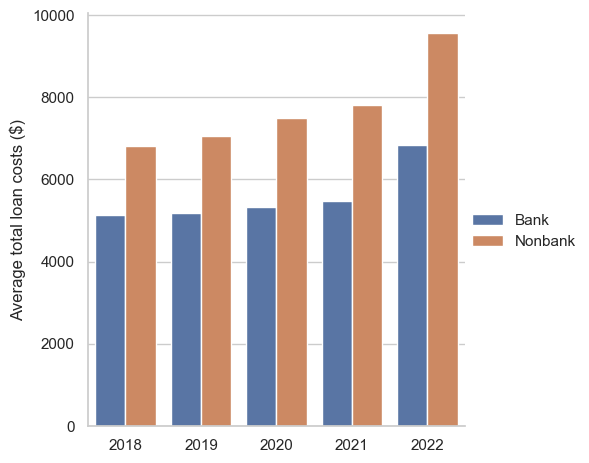

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

per_year_avg['bank'] = per_year_avg['bank'].apply(lambda x:'Bank' if x == True else 'Nonbank')

g = sns.catplot(
    data=per_year_avg, kind="bar",
    x="activity_year", y="avg(total_loan_costs)", hue="bank"
)

g.set_axis_labels("", "Average total loan costs ($)")
g.legend.set_title("")

In [12]:
bank = joined.filter(joined.bank == True)
nonbank = joined.filter(joined.bank != True)

In [13]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=['income','debt_to_income_ratio','loan_amount',
                                       'combined_loan_to_value_ratio','discount_points',
                                       'lender_credits','loan_type','loan_purpose'], 
                            outputCol='features')

lr = LinearRegression(featuresCol='features', labelCol='total_loan_costs', predictionCol='pred_cost', regParam=0.5, elasticNetParam=0.8)

In [14]:
white_data_bank = assembler.transform(
        bank.filter(bank.ethnicity.contains('White'))
).select('features', 'total_loan_costs')

white_data_nonbank = assembler.transform(
        nonbank.filter(nonbank.ethnicity.contains('White'))
).select('features', 'total_loan_costs')

lr_bank = lr.fit(white_data_bank)
lr_nonbank = lr.fit(white_data_nonbank)

24/02/13 18:10:46 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/02/13 18:10:46 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


In [15]:
data_bank = assembler.transform(bank.filter(bank.ethnicity != 'White')).select('features', 'total_loan_costs', 'ethnicity')
data_nonbank = assembler.transform(nonbank.filter(bank.ethnicity != 'White')).select('features', 'total_loan_costs', 'ethnicity')

nonbank_pred= lr_nonbank.transform(data_nonbank)
bank_pred= lr_bank.transform(data_bank)

nonbank_pred = nonbank_pred.withColumn('diff', nonbank_pred.total_loan_costs - nonbank_pred.pred_cost)
bank_pred = bank_pred.withColumn('diff', bank_pred.total_loan_costs - bank_pred.pred_cost)

In [16]:
from pyspark.sql.functions import mean

avg_nonbank = nonbank_pred.groupBy('ethnicity').avg('diff').toPandas()
avg_bank = bank_pred.groupBy('ethnicity').avg('diff').toPandas()

Text(0, -0.8, '| White')

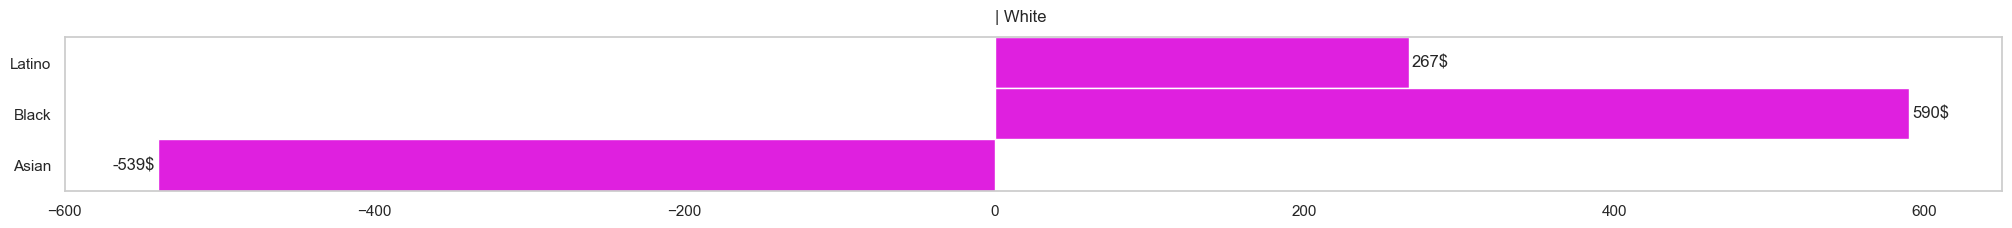

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt


f, ax = plt.subplots(figsize=(25,2))
sns.set_theme(style="whitegrid")

g = sns.barplot(x="avg(diff)", y="ethnicity", data=avg_nonbank,
            label="avg(diff)", color="magenta", width=1.0)

labels = [str(int(x)) + '$' for x in avg_nonbank['avg(diff)']]
ax.bar_label(ax.containers[0], labels=labels, padding=2)
ax.set_xlim(-600, +650)

ax.grid(False)
g.set(xlabel=None)
g.set(ylabel=None)
ax.text(0, -0.8, "| White")

Text(0, -0.8, '| White')

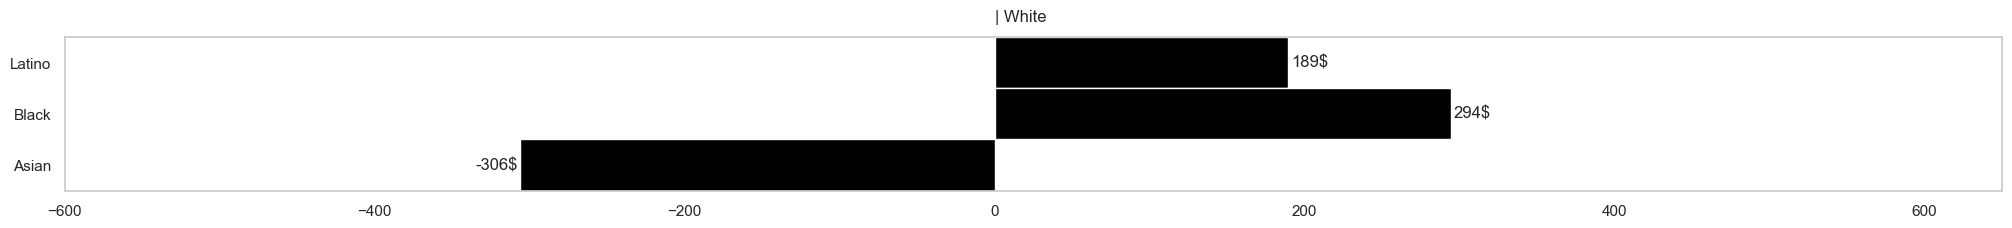

In [18]:
f, ax = plt.subplots(figsize=(25,2))
sns.set_theme(style="whitegrid")

g = sns.barplot(x="avg(diff)", y="ethnicity", data=avg_bank,
            label="avg(diff)", color="black", width=1.0)

labels = [str(int(x)) + '$' for x in avg_bank['avg(diff)']]
ax.bar_label(ax.containers[0], labels=labels, padding=2)
ax.set_xlim(-600, +650)

ax.grid(False)
g.set(xlabel=None)
g.set(ylabel=None)
ax.text(0, -0.8, "| White")